In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from sqlalchemy import create_engine

In [3]:
import joblib

# Loading raw dataset

##### Here I'm going to pull my raw dataset from PostgreSQL

In [4]:
host = r'127.0.0.1'
db = r'MSDS610'
user = r'postgres'
pw = r'MacMVP2025$' 
port = r'5432'
schema = r'raw'

In [5]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [6]:
table_name = r'sales_data_raw'
schema = r'raw'

live_data = pd.read_sql_table(table_name, db_conn, schema)

In [7]:
live_data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,None,None,None,None,...,None,None,None,None,None,NaN,az,NaN,NaN,None
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,None,None,None,None,...,None,None,None,None,None,NaN,ar,NaN,NaN,None
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,None,None,None,None,...,None,None,None,None,None,NaN,fl,NaN,NaN,None
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,None,None,None,None,...,None,None,None,None,None,NaN,ma,NaN,NaN,None
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,None,None,None,None,...,None,None,None,None,None,NaN,nc,NaN,NaN,None


##### Alright I've got my data, now I just need to clean it up exactly as I did with the other dataset. I'll be following the same steps as I did before to ensure uniformity with model performance.

In [8]:
dropped_columns = ['url', 'region', 'region_url', 'image_url', 'county', 'state', 'lat', 'long', 'posting_date', 'description','id','VIN','drive','size','paint_color','title_status']
live_data = live_data.drop(columns=dropped_columns)
live_data.head()


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
0,6000,NaN,None,None,None,None,None,NaN,None,None
1,11900,NaN,None,None,None,None,None,NaN,None,None
2,21000,NaN,None,None,None,None,None,NaN,None,None
3,1500,NaN,None,None,None,None,None,NaN,None,None
4,4900,NaN,None,None,None,None,None,NaN,None,None


In [9]:
live_data = live_data.dropna()
live_data.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,other,pickup
28,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,other,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,other,pickup
30,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,other,pickup
31,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,automatic,truck


In [10]:
live_data['condition'] = live_data['condition'].replace({'salvage': 1, 'fair': 2, 'good': 3, 'excellent': 4, 'like new': 5, 'new': 6})
live_data.head()

/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_18675/1405969253.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  live_data['condition'] = live_data['condition'].replace({'salvage': 1, 'fair': 2, 'good': 3, 'excellent': 4, 'like new': 5, 'new': 6})


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,3,8 cylinders,gas,57923.0,other,pickup
28,22590,2010.0,chevrolet,silverado 1500,3,8 cylinders,gas,71229.0,other,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,3,8 cylinders,gas,19160.0,other,pickup
30,30990,2017.0,toyota,tundra double cab sr,3,8 cylinders,gas,41124.0,other,pickup
31,15000,2013.0,ford,f-150 xlt,4,6 cylinders,gas,128000.0,automatic,truck


In [11]:
live_data['cylinders'] = live_data['cylinders'].str.rstrip(' cylinders')
live_data.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,3,8,gas,57923.0,other,pickup
28,22590,2010.0,chevrolet,silverado 1500,3,8,gas,71229.0,other,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,3,8,gas,19160.0,other,pickup
30,30990,2017.0,toyota,tundra double cab sr,3,8,gas,41124.0,other,pickup
31,15000,2013.0,ford,f-150 xlt,4,6,gas,128000.0,automatic,truck


In [12]:
live_data['fuel'] = live_data['fuel'].replace({'gas': 1, 'diesel': 2, 'other': 3, 'hybrid': 4, 'electric': 5})
live_data.head()

/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_18675/2306400148.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  live_data['fuel'] = live_data['fuel'].replace({'gas': 1, 'diesel': 2, 'other': 3, 'hybrid': 4, 'electric': 5})


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,3,8,1,57923.0,other,pickup
28,22590,2010.0,chevrolet,silverado 1500,3,8,1,71229.0,other,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,3,8,1,19160.0,other,pickup
30,30990,2017.0,toyota,tundra double cab sr,3,8,1,41124.0,other,pickup
31,15000,2013.0,ford,f-150 xlt,4,6,1,128000.0,automatic,truck


In [13]:
live_data['transmission'] = live_data['transmission'].replace({'manual': 1, 'other': 2, 'automatic': 3})
live_data.head()

/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_18675/3219561223.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  live_data['transmission'] = live_data['transmission'].replace({'manual': 1, 'other': 2, 'automatic': 3})


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,3,8,1,57923.0,2,pickup
28,22590,2010.0,chevrolet,silverado 1500,3,8,1,71229.0,2,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,3,8,1,19160.0,2,pickup
30,30990,2017.0,toyota,tundra double cab sr,3,8,1,41124.0,2,pickup
31,15000,2013.0,ford,f-150 xlt,4,6,1,128000.0,3,truck


In [14]:
live_data['type'] = live_data['type'].replace({'sedan': 1, 'SUV': 2, 'pickup': 3, 'truck': 4, 'coupe': 5, 'other': 6, 'hatchback': 7, 'van': 8, 'convertible': 9, 'wagon': 10, 'mini-van': 11, 'offroad': 12, 'bus': 13})
live_data.head()

/var/folders/3d/nb6n2ch91816p9ksz49h0wx00000gn/T/ipykernel_18675/3716328637.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  live_data['type'] = live_data['type'].replace({'sedan': 1, 'SUV': 2, 'pickup': 3, 'truck': 4, 'coupe': 5, 'other': 6, 'hatchback': 7, 'van': 8, 'convertible': 9, 'wagon': 10, 'mini-van': 11, 'offroad': 12, 'bus': 13})


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,3,8,1,57923.0,2,3
28,22590,2010.0,chevrolet,silverado 1500,3,8,1,71229.0,2,3
29,39590,2020.0,chevrolet,silverado 1500 crew,3,8,1,19160.0,2,3
30,30990,2017.0,toyota,tundra double cab sr,3,8,1,41124.0,2,3
31,15000,2013.0,ford,f-150 xlt,4,6,1,128000.0,3,4


In [15]:
live_data['year'] = live_data['year'].astype(int)

In [16]:
live_data['price_ratio'] = live_data['price'] / live_data['price'].max()

In [17]:
live_data['mileage_ratio'] = live_data['odometer'] / live_data['odometer'].max()

In [18]:
live_data = live_data.drop(['manufacturer', 'model'], axis=1)

In [19]:
oth_cylinders = 'oth'
drop_typos = live_data[live_data['cylinders'] == oth_cylinders].index
live_data = live_data.drop(drop_typos)

In [20]:
live_data['cylinders'] = live_data['cylinders'].astype(int)

In [21]:
live_data.dtypes

price              int64
year               int64
condition          int64
cylinders          int64
fuel               int64
odometer         float64
transmission       int64
type               int64
price_ratio      float64
mileage_ratio    float64
dtype: object

In [22]:
live_data['odometer'] = live_data['odometer'].astype(int)

In [23]:
live_data['cylinders'] = live_data['cylinders'].astype(int)

In [24]:
live_data.head()

,price,year,condition,cylinders,fuel,odometer,transmission,type,price_ratio,mileage_ratio
27,33590,2014,3,8,1,57923,2,3,0.000009,0.005792
28,22590,2010,3,8,1,71229,2,3,0.000006,0.007123
29,39590,2020,3,8,1,19160,2,3,0.000011,0.001916
30,30990,2017,3,8,1,41124,2,3,0.000008,0.004112
31,15000,2013,4,6,1,128000,3,4,0.000004,0.012800


In [25]:
import sklearn

In [26]:
live_data.columns

Index(['price', 'year', 'condition', 'cylinders', 'fuel', 'odometer',
       'transmission', 'type', 'price_ratio', 'mileage_ratio'],
      dtype='object')

##### Now that I've got my data cleaned, I can constuct my model. I ran into some kernal crashing issues while using joblib so I decided to copy over the model. I can confirm that joblib was working initially.

In [27]:
X = live_data.drop(columns=['price'])
y = live_data['price']

##### The line of code below is there because of an error I had gotten when running the Random Forest Classifier.

In [28]:
X = X.rename(str,axis="columns")

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
classi = RandomForestClassifier(n_estimators=25, random_state=42)
classi.fit(X_train, y_train)

importances = classi.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [32]:
live_data = live_data.rename(str,axis="columns")

In [34]:
predictions = classi.predict(X)

In [35]:
predictions

array([33590, 22590, 39590, ..., 29590, 32990, 28990])

##### Now we've got our prediction, it's time to add them to our data and see how the model performed.

In [38]:
raw_sales = pd.read_csv('vehicles.csv')
raw_sales.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [42]:
predictions_df = pd.DataFrame({'predictions': predictions})
raw_sales_predict = pd.concat([raw_sales.reset_index(drop=True), predictions_df.reset_index(drop=True)], axis=1)

In [43]:
raw_sales_predict.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,type,paint_color,image_url,description,county,state,lat,long,posting_date,predictions
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN,33590.0
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN,22590.0
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN,39590.0
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN,30990.0
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN,8990.0


##### Perfect, now I've got my predictions added to my data. Time to upload to PostgreSQL.

In [48]:
host = r'127.0.0.1'
db = r'MSDS610'
user = r'postgres'
pw = r'MacMVP2025$' 
port = r'5432'
schema = r'analytic' 

In [49]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [50]:
sql="select tables.table_name from information_schema.tables where (table_schema ='"+schema+"')order by 1;"
tbl_df = pd.read_sql(sql, db_conn, index_col=None)
tbl_df

,table_name


In [51]:
table_name = r'raw_sales_predict'

In [52]:
raw_sales_predict.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')


426880

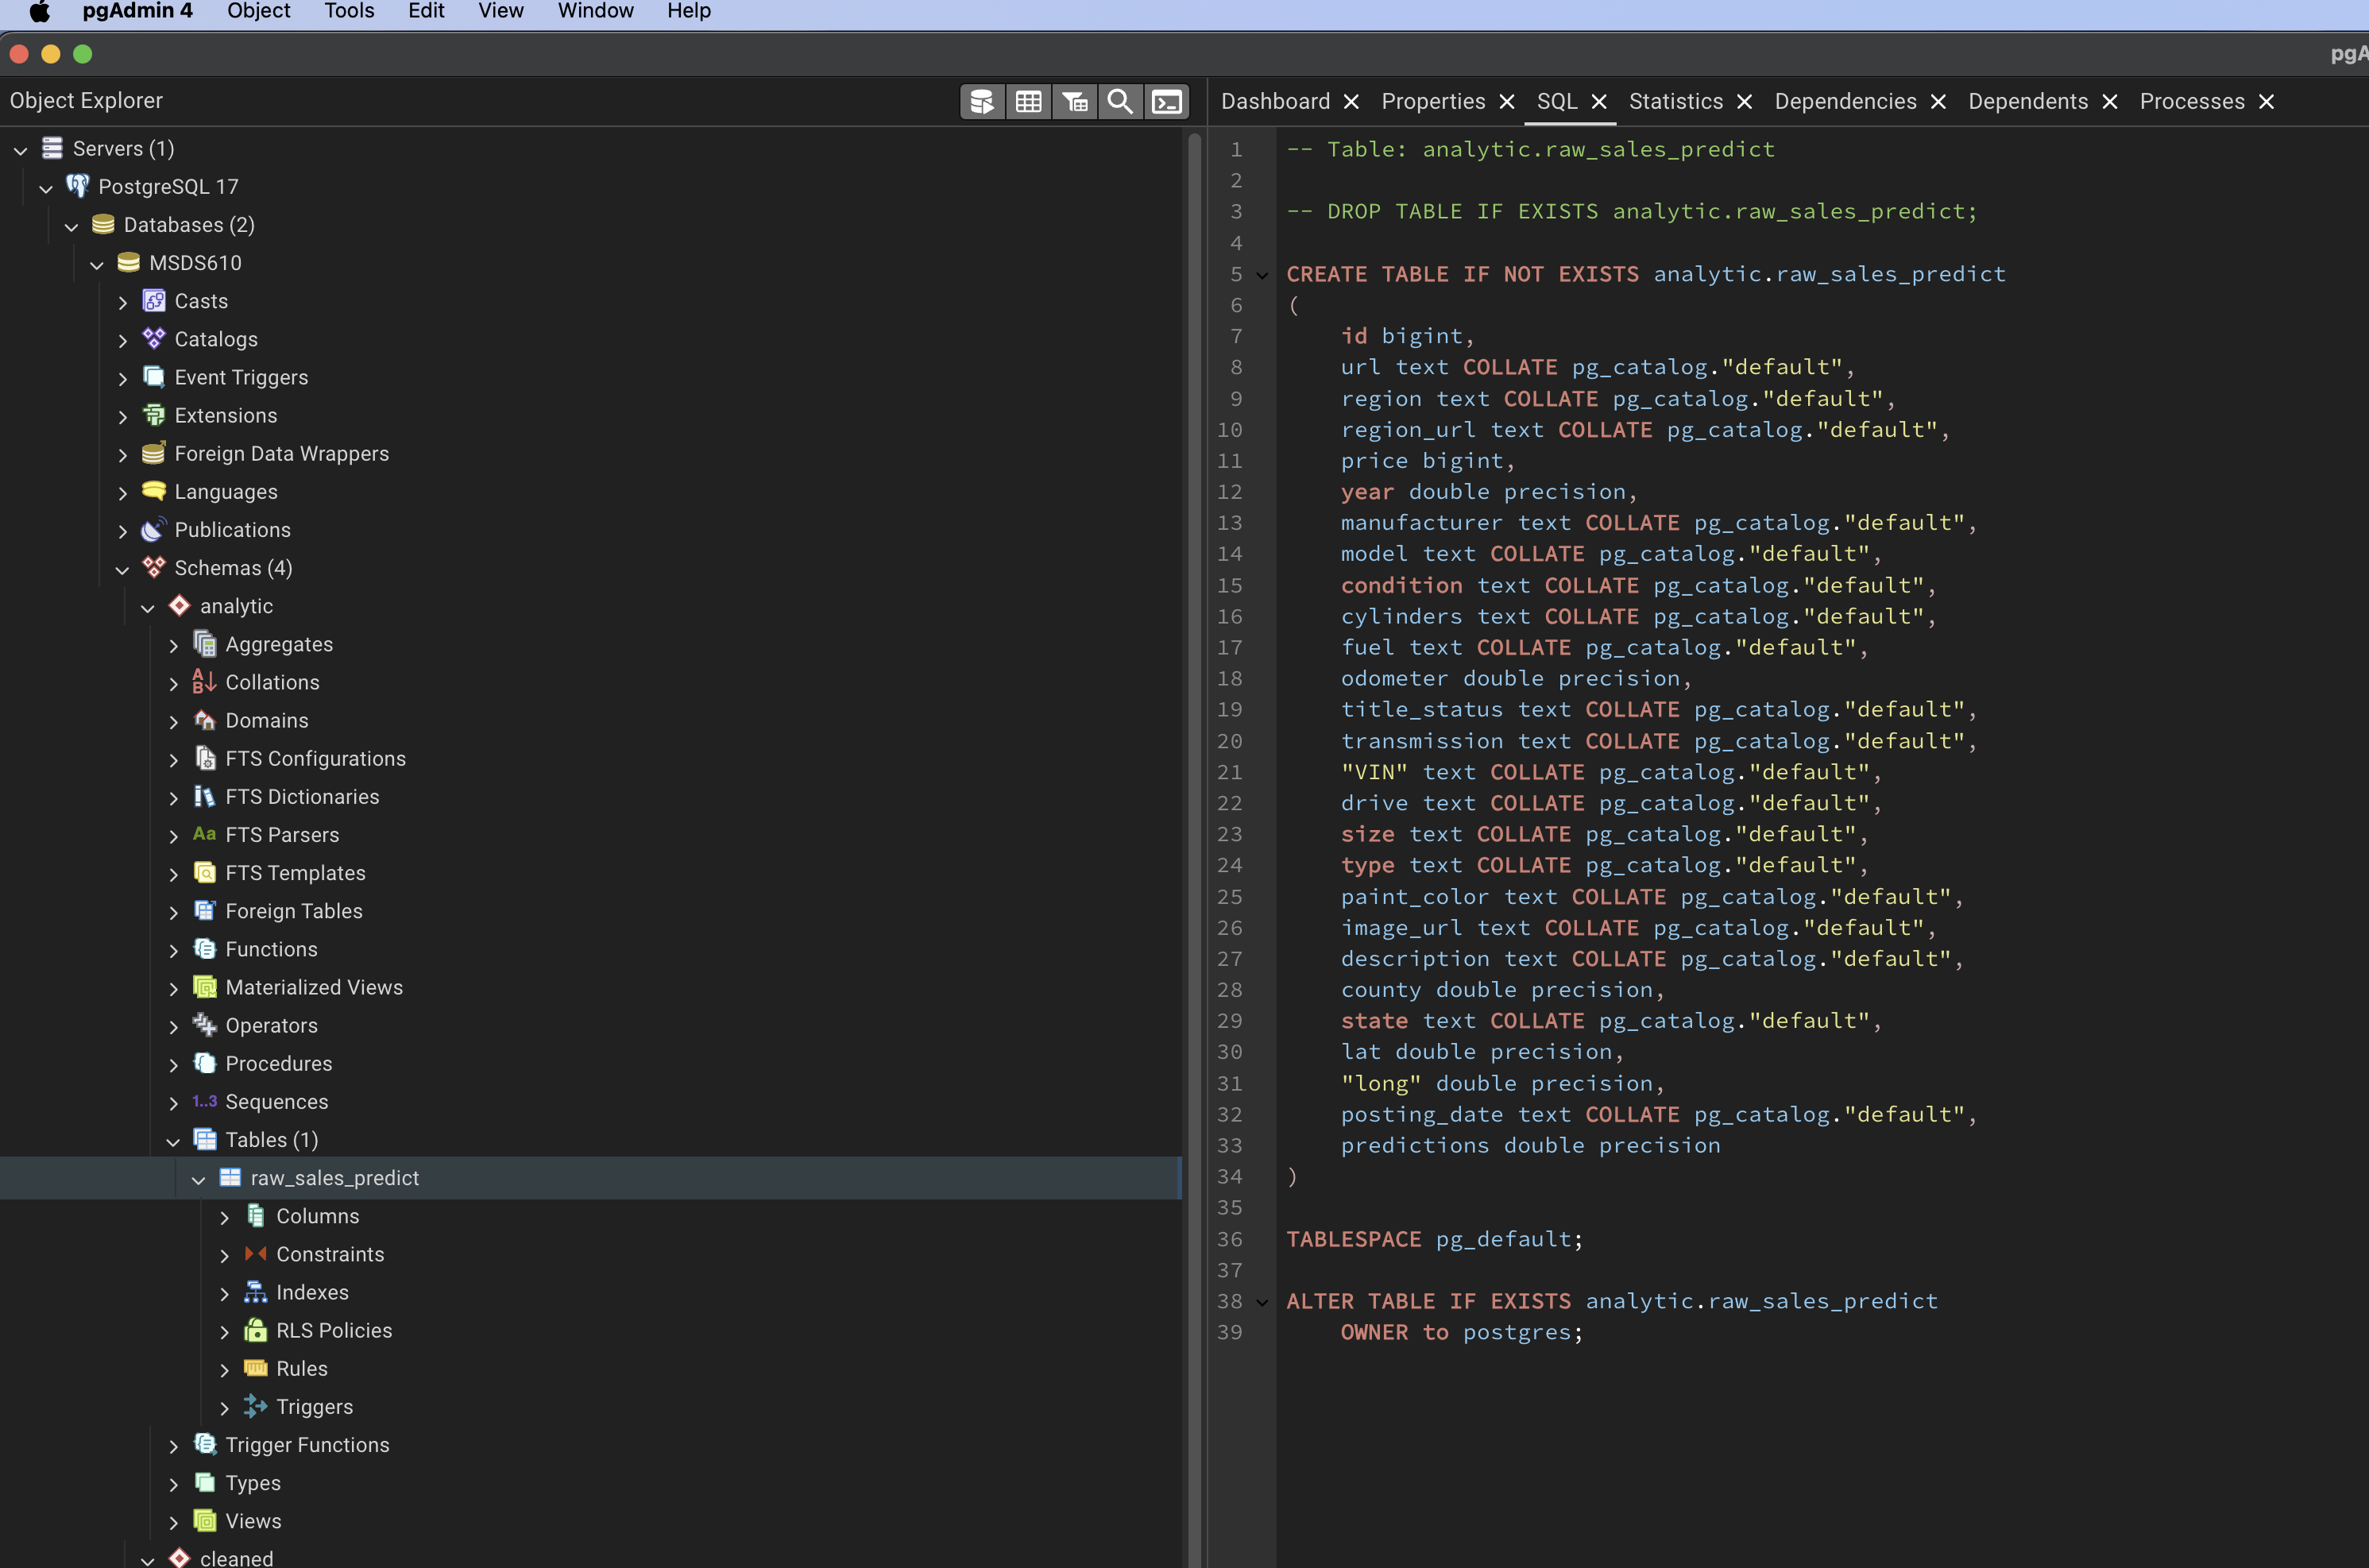

In [55]:
raw_sales_predict.head(20)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,type,paint_color,image_url,description,county,state,lat,long,posting_date,predictions
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN,33590.0
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN,22590.0
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN,39590.0
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN,30990.0
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN,8990.0
5,7222379453,https://hudsonvalley.craigslist.org/cto/d/west...,hudson valley,https://hudsonvalley.craigslist.org,1600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN,27990.0
6,7221952215,https://hudsonvalley.craigslist.org/cto/d/west...,hudson valley,https://hudsonvalley.craigslist.org,1000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN,34590.0
7,7220195662,https://hudsonvalley.craigslist.org/cto/d/poug...,hudson valley,https://hudsonvalley.craigslist.org,15995,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN,35000.0
8,7209064557,https://medford.craigslist.org/cto/d/grants-pa...,medford-ashland,https://medford.craigslist.org,5000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,or,NaN,NaN,NaN,29990.0
9,7219485069,https://erie.craigslist.org/cto/d/erie-2012-su...,erie,https://erie.craigslist.org,3000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,pa,NaN,NaN,NaN,38590.0


How much should each vehicle cost based on their characteristics?

# Summary

##### Well looking at my data compared to my predictions I'm a bit disappointed. I'm happy that the I was able to generate predictions but they seem to be pretty far of what the actual prices are for these vehicles. I was able to answer the analytical question but the answer was unfortunately not very accurate. I hope over time I'll learn to build a more accurate model for making predictions like these.

# Reflection

##### This was definitely a challenge for me but I learned a lot working on this project. The things that challenged me the most are errors coming up unexpectedly and really trying to build an accurate model. I'm learning and growing in this discipline but it is certainly a slow process.

##### I enjoyed most of this project. I think building predictive models is really a cool thing to try to do. I think what I most enjoy is thinking about the things I could potentially learn and find out with ML models. I also thought it was cool to simulate getting a model to production. The entire class I've been thinking about how we always talk about how in the real world we're constantly getting new data but hadn't practiced that until this assignment so it was great to get that experience.

##### I definitely have a better understanding now than when I started this project on how to get a model to production. There so much more for me to learn but this one taught me a lot. I will say this project was humbling, but it felt good to put in the work.